In [1]:
!nvidia-smi

Fri Jul  8 03:27:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 24%   38C    P0    57W / 260W |      5MiB / 11019MiB |     24%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!mkdir checkpoints
!wget https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth -P checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-07-08 03:27:48--  https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196205945 (187M) [application/octet-stream]
Saving to: ‘checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth.2’

pspnet_r50-d8_512x1 100%[===================>] 187.12M  6.98MB/s    in 24s     

2022-07-08 03:28:14 (7.95 MB/s) - ‘checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth.2’ saved [196205945/196205945]



In [3]:
data_root = '../data/dataset1/'
train_img_dir = 'train_img'
train_ann_dir = 'train_label'

test_img_dir = 'train_img'
test_ann_dir = 'train_label'

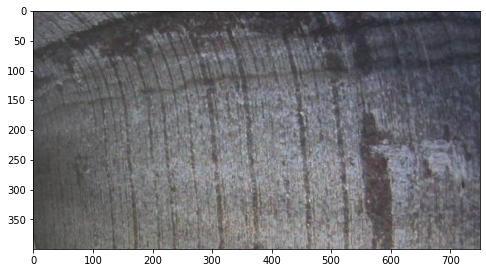

In [4]:
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt
%matplotlib inline 

img = mmcv.imread('../data/dataset1/train_img/10631_2019-02-08-00-51-44_Borer_21_TopbarRight.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [5]:
import os.path as osp
import numpy as np
from PIL import Image
# define class and plaette for better visualization
classes = ('no_seam','seam')
palette = [[0,0,0],[255,255,255]]

In [6]:
from PIL import Image
import numpy as np
import os, sys

def format_mask_white(path):
    dirs = os.listdir(path)
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            im_rgb = im.convert(mode='RGB')
            data = np.copy(np.asarray(im_rgb))
            data[data==1] = 255
            img = Image.fromarray(data, 'RGB')
            img.save(path+item)   
        
# format_mask_white("../data/dataset1/train_label/")
# format_mask_white("../data/dataset1/test_label/")

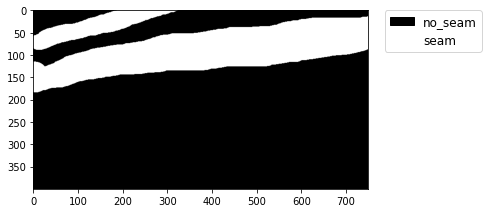

In [7]:
# Examine the segmentation map
import numpy as np
import sys
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import glob as glob
%matplotlib inline 

from PIL import Image
import glob
image_list = []
os.makedirs('gt', exist_ok=True)

filename = '../data/dataset1/train_label/10631_2019-02-08-00-51-44_Borer_21_TopbarRight.png'
im=Image.open(filename)
im_rgb = im.convert(mode='RGB')
data = np.copy(np.asarray(im_rgb))
data[data==1] = 255
img = Image.fromarray(data, 'RGB')
plt.imshow(img)
# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                            label=classes[i]) for i in range(len(classes))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
            fontsize='large')
plt.show()
# img.save(filename.replace('../data/dataset1/train_label/','gt/'))

In [8]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))

filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, train_ann_dir), suffix='.png')]

with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  f.writelines(line + '\n' for line in filename_list)
   
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, test_ann_dir), suffix='.png')]

with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  f.writelines(line + '\n' for line in filename_list)

In [9]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class ClaySeamDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

    

In [10]:
from mmcv import Config
cfg = Config.fromfile('../mmsegmentation/configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

In [11]:
from mmseg.apis import set_random_seed

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

# Modify dataset type and path
cfg.dataset_type = 'ClaySeamDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu=8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = train_img_dir
cfg.data.train.ann_dir = train_ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = test_img_dir
cfg.data.val.ann_dir = test_ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = test_img_dir
cfg.data.test.ann_dir = test_ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=F

In [12]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

/opt/conda/lib/python3.7/site-packages/mmcv/utils/misc.py:324: UserWarning: "flip_ratio" is deprecated in `RandomFlip.__init__`, please use "prob" instead
  f'"{src_arg_name}" is deprecated in '
2022-07-08 03:28:18,917 - mmseg - INFO - Loaded 3872 images
/usr/src/research/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
2022-07-08 03:28:20,998 - mmseg - INFO - Loaded 3872 images
2022-07-08 03:28:20,999 - mmseg - INFO - load checkpoint from checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
2022-07-08 03:28:20,999 - mmseg - INFO - Use load_from_local loader
2022-07-08 03:28:21,142 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 3872/3872, 36.8 task/s, elapsed: 105s, ETA:     0s

2022-07-08 03:30:52,016 - mmseg - INFO - per class results:
2022-07-08 03:30:52,018 - mmseg - INFO - 
+---------+-------+-------+
|  Class  |  IoU  |  Acc  |
+---------+-------+-------+
| no_seam | 89.58 | 94.76 |
|   seam  | 66.66 | 79.22 |
+---------+-------+-------+
2022-07-08 03:30:52,018 - mmseg - INFO - Summary:
2022-07-08 03:30:52,019 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.38 | 78.12 | 86.99 |
+-------+-------+-------+
2022-07-08 03:30:52,027 - mmseg - INFO - Iter(val) [3872]	aAcc: 0.9138, mIoU: 0.7812, mAcc: 0.8699, IoU.no_seam: 0.8958, IoU.seam: 0.6666, Acc.no_seam: 0.9476, Acc.seam: 0.7922


In [13]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [16]:
import cv2
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette
img = mmcv.imread('../data/dataset1/train_img/10631_2019-02-08-00-51-44_Borer_21_TopbarRight.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
# Make this output to file
out_file='test.png'
img = model.show_result(img, result, palette=palette, show=False, opacity=0.5)
mmcv.imwrite(img, out_file)

True

<Figure size 576x432 with 0 Axes>

In [ ]:
os.makedirs('inference', exist_ok=True)
    
for filename in glob.glob('../data/dataset1/train_img/*.jpg'):
    img = mmcv.imread(filename)
    model.cfg = cfg
    result = inference_segmentor(model, img)
    plt.figure(figsize=(8, 6))
    img = model.show_result(img, result, palette=palette, show=False, opacity=0.5)
    mmcv.imwrite(img,filename.replace('../data/dataset1/train_img/','inference/'))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
